# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm



## Personal adjustments

In [86]:
# Custom files location on data partition
import os
import numpy as np
import torch
import torch.nn
import torch.nn.functional as F

dog_dir = "/data/picost/ml_samples/dogImages"
human_dir = "/data/picost/ml_samples/lfw"

# Some usefull ressources
import ressources

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:
* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dogImages`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [87]:
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob(os.path.join(human_dir,"*/*")))
dog_files = np.array(glob(os.path.join(dog_dir, "*/*/*")))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


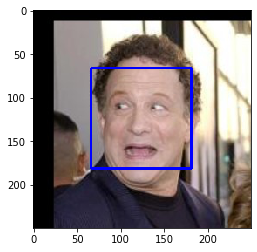

In [88]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [89]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
(You can print out your results and/or write your percentages in this cell)

In [90]:
#from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

human_detected = list(map(face_detector, human_files_short))
n_positives = sum(human_detected)
print("The humans were positively detected in [{}]% "
      "cases in the human samples".format(n_positives / len(human_files_short) * 100))

The humans were positively detected in [99.0]% cases in the human samples


In [91]:
dog_human_detected = list(map(face_detector, dog_files_short))
n_false_positives = sum(dog_human_detected)
print("There were [{}]% of false-positive human detection cases in the "
      "dog samples".format(n_false_positives / len(dog_files_short) * 100))

There were [8.0]% of false-positive human detection cases in the dog samples


/data/picost/ml_samples/dogImages/test/012.Australian_shepherd/Australian_shepherd_00853.jpg


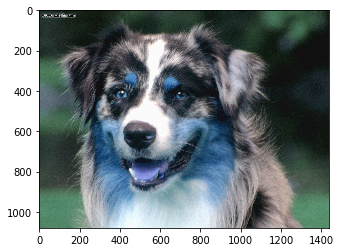

/data/picost/ml_samples/dogImages/test/057.Dalmatian/Dalmatian_04030.jpg


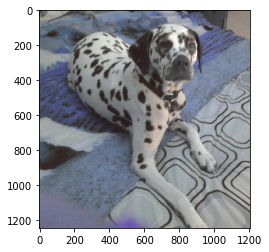

/data/picost/ml_samples/dogImages/test/057.Dalmatian/Dalmatian_04076.jpg


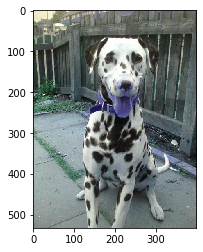

/data/picost/ml_samples/dogImages/test/072.German_shorthaired_pointer/German_shorthaired_pointer_04980.jpg


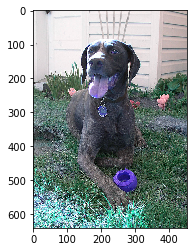

/data/picost/ml_samples/dogImages/test/002.Afghan_hound/Afghan_hound_00151.jpg


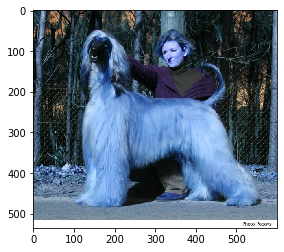

/data/picost/ml_samples/dogImages/test/089.Irish_wolfhound/Irish_wolfhound_06050.jpg


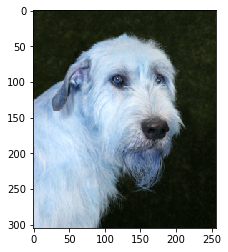

/data/picost/ml_samples/dogImages/test/076.Golden_retriever/Golden_retriever_05248.jpg


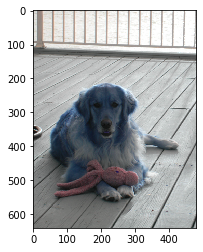

/data/picost/ml_samples/dogImages/test/056.Dachshund/Dachshund_03995.jpg


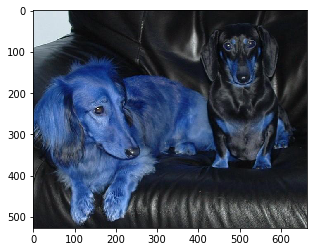

In [92]:
import matplotlib.pyplot as plt

for ind, human in enumerate(list(dog_human_detected)):
    if human:
        print(dog_files_short[ind])
        img = cv2.imread(dog_files_short[ind])
        plt.imshow(img)
        plt.show()

Taking a quick look at the False positive let us see that only one of the eight cases is due of the presence of a human in the dog picture.

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [93]:
### (Optional) 
### TODO: Test performance of another face detection algorithm.
### Feel free to use as many code cells as needed.

# 1 create a dataset of shuffled dog and human images with labels

# 2 train a CNN

# 3 test it


# -----> build a CNN to classify dogs vs humans

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [94]:
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device : [{}]".format(device))

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
VGG16 = VGG16.to(device)

Using device : [cpu]


Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

In [95]:
VGG16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

The following cell contains a function to load an image as defined from the style-transfer notebook in the course.

In [96]:
from torchvision import transforms

def load_image(img_path, max_size=400, shape=None):
    ''' Load in and transform an image, making sure the image
       is <= 400 pixels in the x-y dims.
       
    Args:
    
        img_path (str): path from where the image has to be loaded
        max_size (int, optional): size threshold beyond which images are
            resized to this value.
        shape (int, tuple, optional): if provided, images are reshaped
            accordingly.
            
    Return
    
        Tensor: image as torch tensor with 3 channels
       
    '''
    if "http" in img_path:
        response = requests.get(img_path)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(img_path).convert('RGB')
    # large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    if shape is not None:
        size = shape
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])
    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    return image

In [97]:
from PIL import Image

# Set PIL to be tolerant of image files that are truncated.
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    vgg_in = load_image(img_path, shape=(224, 224))
    ## Return the *index* of the predicted class for that image
    vgg_in = vgg_in.to(device)
    vgg_pred = VGG16(vgg_in)
    top_score, top_index = vgg_pred.topk(1, dim=1)
    return top_index # predicted class index

Test the function on a the dog file uses as example in the text:

In [98]:
dog_path_example = os.path.join(dog_dir,'train/001.Affenpinscher/Affenpinscher_00001.jpg')
class_index = VGG16_predict(dog_path_example).item()
ressources.vgg_class_labels[class_index]

'affenpinscher, monkey pinscher, monkey dog'

Result is correct for this example.

In [99]:
non_dog_path_example = os.path.join(human_dir, 'Zydrunas_Ilgauskas', 'Zydrunas_Ilgauskas_0001.jpg')
class_index = VGG16_predict(non_dog_path_example).item()
ressources.vgg_class_labels[class_index]

'horizontal bar, high bar'

Ok since no human in label classes: this is not a dog!

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [100]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    """Return True iff a dog is in the provided image
    
    Args: 
    
        img_path (str): path toward a file containing an image to be tested
        
    Returns:
    
        bool : True iff a dog is present in the image
    
    """
    label = VGG16_predict(img_path).item()
    return (label > 150 and label < 269)

In [101]:
dog_detector(dog_path_example)

True

In [102]:
dog_detector(non_dog_path_example)

False

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 


In [103]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
dogs_detected = list(map(dog_detector, dog_files_short))
n_positives = sum(dogs_detected)
print("Dogs were detected with an accuracy of [{}]%".format(n_positives / len(dog_files_short) * 100))

Dogs were detected with an accuracy of [100.0]%


In [104]:
dogs_detected = list(map(dog_detector, human_files_short))
n_positives = sum(dogs_detected)
print("Dogs were detected in [{}]% of human sample images".format(n_positives / len(dog_files_short) * 100))

Dogs were detected in [1.0]% of human sample images


Dog detected in : /data/picost/ml_samples/lfw/Albert_Brooks/Albert_Brooks_0001.jpg


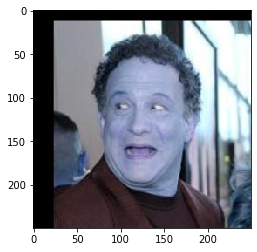

In [105]:
ind = dogs_detected.index(1) # True == 1 in Python
print("Dog detected in :", human_files_short[ind])
img = cv2.imread(human_files_short[ind])
plt.imshow(img)
plt.show()

We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [106]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [21]:
from torchvision import datasets

batch_size = 16
imsize = 80

transform = transforms.Compose([
    transforms.Resize(int(imsize * 1.2) ),
    transforms.RandomHorizontalFlip(), # randomly flip and rotate
    #transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.RandomCrop(imsize),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), 
                         (0.229, 0.224, 0.225)),
    ])

test_transform = transforms.Compose([
    transforms.Resize(int(imsize * 1.2) ),
    transforms.CenterCrop(imsize),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), 
                         (0.229, 0.224, 0.225)),
    ])

# Training Dataset
train_dir = os.path.join(dog_dir, 'train')
train_set = datasets.ImageFolder(train_dir, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, 
                                           shuffle=True)
# validation Dataset
valid_dir = os.path.join(dog_dir, 'valid')
valid_set = datasets.ImageFolder(valid_dir, transform=test_transform)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, 
                                           shuffle=True)
# Test Dataset
test_dir = os.path.join(dog_dir, 'test')
test_set = datasets.ImageFolder(test_dir, transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, 
                                          shuffle=True)

loaders_scratch = {'train': train_loader,
                   'valid': valid_loader,
                   'test': test_loader}

In [22]:
n_class = 133

In [23]:
n_train = len(train_set)
n_valid = len(valid_set)
n_test = len(test_set)
print("There are {} images for training, {} for validation and {} for testing".format(n_train, n_valid, n_test))

There are 6680 images for training, 835 for validation and 836 for testing


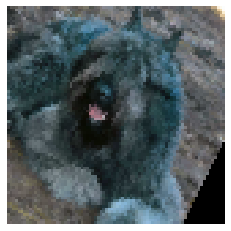

In [24]:
import helpers
images, labels = next(iter(train_loader))
helpers.imshow(images[0], normalize=True)

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [25]:
from cifar_model.dog_classifier import Net

# instantiate the CNN
model_scratch = Net(n_class, imsize)

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 

Tried various architecture with more or less convolutional layers.
Face the problem of vanishing gradient? -> network quickly stuck at a given error rate with no movement.

Tried simplifying the problem and making it less expensive as (shallower network, lower image resolution):
* I train locally
* There is few data (<7000 images) vs number of classes to be discriminated!

http://neuralnetworksanddeeplearning.com/chap5.html -> problems occuring when training deep networks

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [30]:
import torch.optim as optim

### TODO: select loss function
criterion_scratch = torch.nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer_scratch = optim.Adam(model_scratch.parameters(), lr=0.001)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [31]:
model_scratch.load_state_dict(torch.load('cifar_model/model.pt'))

<All keys matched successfully>

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [31]:
model_scratch.load_state_dict(torch.load('cifar_model/model.pt'))

<All keys matched successfully>

In [72]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [32]:
# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.660889


Test Accuracy: 27% (230/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [57]:
batch_size = 16
imsize = 224

transform = transforms.Compose([
    transforms.Resize(int(imsize * 1.2) ),
    transforms.RandomHorizontalFlip(), # randomly flip and rotate
    #transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.RandomCrop(imsize),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), 
                         (0.229, 0.224, 0.225)),
    ])

test_transform = transforms.Compose([
    transforms.Resize(int(imsize * 1.2) ),
    transforms.CenterCrop(imsize),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), 
                         (0.229, 0.224, 0.225)),
    ])

# Training Dataset
train_dir = os.path.join(dog_dir, 'train')
train_set = datasets.ImageFolder(train_dir, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, 
                                           shuffle=True)
# validation Dataset
valid_dir = os.path.join(dog_dir, 'valid')
valid_set = datasets.ImageFolder(valid_dir, transform=test_transform)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, 
                                           shuffle=True)
# Test Dataset
test_dir = os.path.join(dog_dir, 'test')
test_set = datasets.ImageFolder(test_dir, transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, 
                                          shuffle=True)

loaders_transfer = {'train': train_loader,
                    'valid': valid_loader,
                    'test': test_loader}


### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [141]:
import torchvision.models as models
import torch.nn as nn

## TODO: Specify model architecture 

model_transfer = models.vgg16(pretrained=True)
# Freeze training for all "features" layers
for param in model_transfer.features.parameters():
    param.requires_grad = False
    
# reset last layers weights for optim
model_transfer.classifier[6].out_features = n_class
for elt in [0,3,6]:
    n_in_layer = model_transfer.classifier[elt].in_features
    model_transfer.classifier[elt].weight.data.normal_(0, 1/np.sqrt(n_in_layer))
for param in model_transfer.classifier.parameters():
    param.requires_grad = True

if use_cuda:
    model_transfer = model_transfer.cuda()

In [142]:
model_transfer

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 

Initially, I had no clue about how to chose a starting point among the models available in torchvision. I took a look at the available models, their accuracies and structures as well as the main idea that lead to tadopt them. Finally, I decided to give a try with a model:
1. which last layers were dense linear ones 
2. with a small numbrer of parameters to be trained.

Point n.2 looked to be good in the sense that optimization comlexity seemed reduced, with the risk of uncertain generalization ability.

First test with Mobilenet was a failure.


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [143]:
criterion_transfer = torch.nn.CrossEntropyLoss()
optimizer_transfer = optim.Adam(model_scratch.parameters(), lr=0.001)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [139]:
train_dir = 'vgg16_transfer'
save_name = 'model_transfer.pt'

In [114]:
model_transfer.load_state_dict(torch.load(os.path.join(train_dir, save_name)))

<All keys matched successfully>

In [ ]:
import imp
imp.reload(my_utils.train_helper)
from my_utils.train_helper import train_model
model_transfer = train_model(model_transfer, loaders_transfer, criterion_transfer, 
                             optimizer_transfer, train_dir=train_dir, save_name=save_name, 
                             n_epochs=10)


# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load(os.path.join(train_dir, save_name)))

Starting epoch [1]


### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [73]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 4.970115


Test Accuracy:  0% ( 3/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [82]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in train_set.classes]

def predict_breed_transfer(img_path):
    """Return the most likely detected dog breed in the image.
    
    Args:
    
        img_path (str): path toward the image where the dog is looked for
        
    Returns:
    
        str: name of the most likely detected dog breed in the image
    
    """
    image = load_image(img_path, shape=(224, 224))
    top_score, top_class = model_transfer(image).topk(1, dim=1)
    breed = class_names[int(top_class.item())]
    # load the image and return the predicted breed
    return breed

In [83]:
predict_breed_transfer(dog_path_example)

'Clumber spaniel'

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [110]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def run_app(img_path):
    dog = dog_detector(img_path)
    human = face_detector(img_path)
    if not (human or dog):
        raise ValueError("Image contains neither a dog or a human, sorry")
    breed = predict_breed_transfer(img_path)
    if dog and human:
        print('UhOh! Looks like we met a werewolf?')
        print('This creature looks like a {}'.format(breed))
    elif dog:
        print('Oooh, look at this cute little {}'.format(breed))
    else:
        print("According to the Holly Great Computer, this human looks like a {}".format(breed))
    img = cv2.imread(img_path)
    plt.imshow(img)
    plt.show()
    return breed
    
    


---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)

UhOh! Looks like we met a werewolf?
This creature looks like a Belgian sheepdog


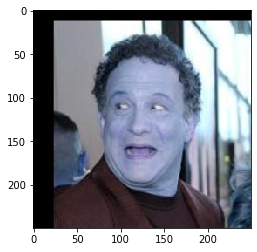

According to the Holly Great Computer, this human looks like a Clumber spaniel


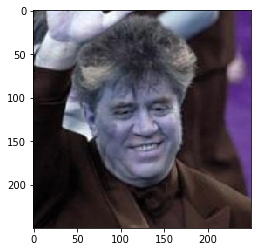

According to the Holly Great Computer, this human looks like a Belgian sheepdog


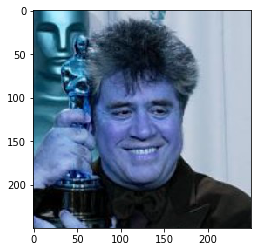

Oooh, look at this cute littel Collie


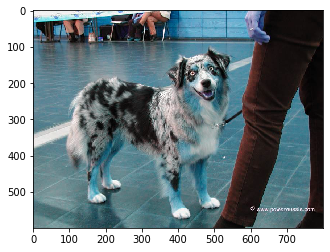

UhOh! Looks like we met a werewolf?
This creature looks like a Norwich terrier


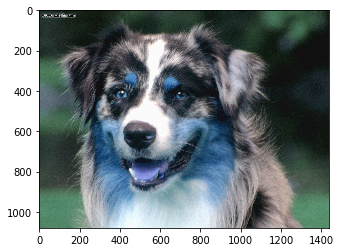

Oooh, look at this cute littel Smooth fox terrier


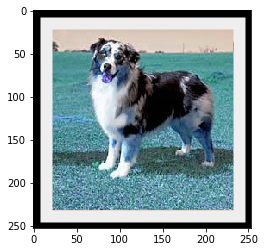

In [111]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

## suggested code, below
for file in np.hstack((human_files[:3], dog_files[:3])):
    run_app(file)

# Now let's have fun

According to a well spread idea, dogs and masters often look alike. Let's see if our predictor agrees with that!

I've downloaded a few dog-master couples from [this blog post](https://positivr.fr/ressemblance-maitre-chien-gerrard-gethings/). Let's see if our algorithm classifies them accordingly!